In [1]:
# import the important packages
from bs4 import BeautifulSoup as bs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-whitegrid')
#from sklearn.preprocessing import StandardScale
import os

# define functions

# reads data from an xml-file
def read_data(file):
    with open(file, 'r') as f:
        data = f.read() 
    bs_data = bs(data, 'xml') 
    return bs_data

# abstract out the calculation for euclidian distances
def calc(b_name, i):
    a1 = b_name[i].find_all('component')[0].get('data')
    b1 = b_name[i].find_all('component')[1].get('data')
    c1 = b_name[i].find_all('component')[2].get('data')
    x = np.asarray([float(x) for x in a1.split(',')])
    y = np.asarray([float(y) for y in b1.split(',')])
    z = np.asarray([float(z) for z in c1.split(',')])
    r = (x**2 + y**2 + z**2)**0.5
    # print(a1)
    return r

# calculates distance based on data, returns a dataframe
def calc_euclidian_distances(bs_data, low, high):
    b_name = bs_data.find_all('name')

    attributes = []
    # finds all values 
    for i in range(len(b_name)):
        attributes.append(b_name[i].get('value'))

    attributes = list(attributes)
    collection = {}
    #print(attributes)
    
    # finds x-, y- and z-values and computes euclidian distance
    # for first values
    for i in range(low, high):
        r = calc(b_name, i)
        collection[attributes[i]] = r

    df = pd.DataFrame(collection)
    return df

In [4]:
i = 0
df_list = []
for xml_file in os.listdir("../Timeseries"):
    if xml_file.startswith("timeseries"):
        #print(xml_file)
        bs_data = read_data("../Timeseries/" + xml_file)
        b_name = bs_data.find_all('name')
        try:
            df1 = calc_euclidian_distances(bs_data, 0, int(len(b_name)/4))
            df1 = pd.DataFrame(df1.mean().to_dict(),index=[df1.index.values[-1]])
            df1 = df1.rename(index={100:i})

            df_list.append(df1)
        except:
            print(xml_file + " failed to compute")
        i += 1

result = pd.concat(df_list)
data = result

timeseries-11.xml failed to compute
timeseries-45.xml failed to compute
timeseries-6.xml failed to compute


C:\Users\linne\Documents\Chalmers\Tracks\BikeFit\env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Histogram of feature means'}, xlabel='Means', ylabel='Frequency'>

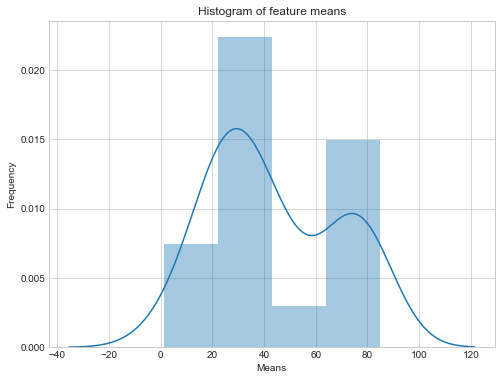

In [5]:
feature_means = data.mean(axis=0)
plt.figure(figsize = (8,6))
plt.title('Histogram of feature means')
plt.xlabel('Means')
plt.ylabel('Frequency')
sns.distplot(a = feature_means)

C:\Users\linne\Documents\Chalmers\Tracks\BikeFit\env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Histogram of feature variances'}, xlabel='Variances', ylabel='Frequency'>

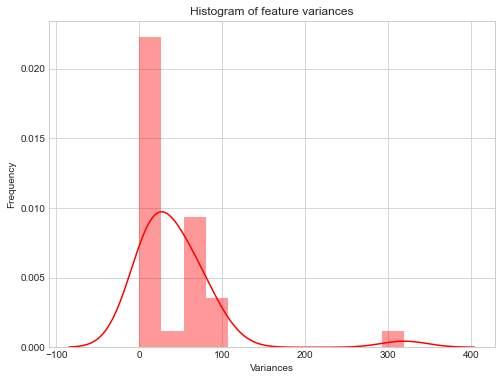

In [6]:
feature_var = data.var(axis = 0)
plt.figure(figsize = (8,6))
plt.title('Histogram of feature variances')
plt.xlabel('Variances')
plt.ylabel('Frequency')
sns.distplot(a = feature_var, color = 'r')


Text(0, 0.5, 'Explained variance')

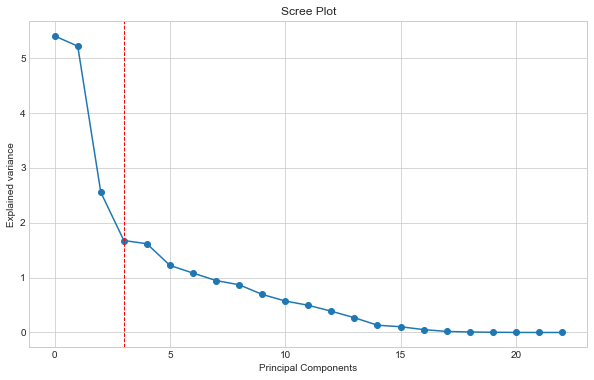

In [7]:
data.loc[:, (data == "null").any(axis = 0) ]

na = data.dropna(axis=1)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


scaler = StandardScaler()
scaled_data = scaler.fit_transform(na)
pca = PCA().fit(scaled_data)
pca_reduced_data = pca.transform(scaled_data)


plt.figure(figsize = (10,6))
plt.plot(range(23), pca.explained_variance_[:50], '-o')
plt.axvline(3, color = 'red', linestyle = 'dashed', linewidth = 1)
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained variance')


<Figure size 864x504 with 0 Axes>

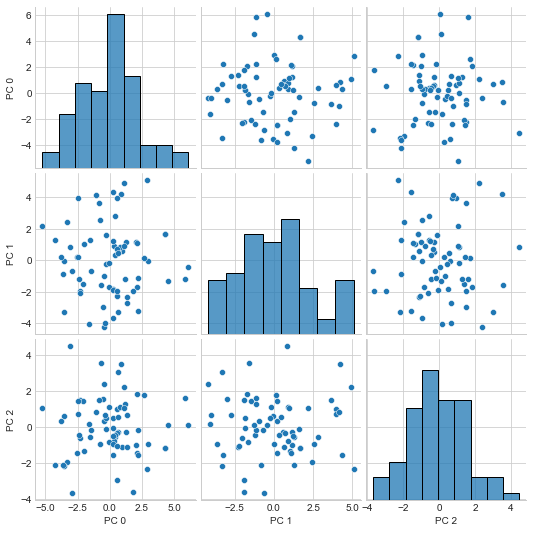

In [8]:
pca_selected_data = pca_reduced_data[:, :5]
pca_selected_data.shape[1]
columns = []
for i in range(pca_selected_data.shape[1]):
    columns.append(f"PC {i}")
plt.figure(figsize = (12,7))
sns.pairplot(pd.DataFrame(pca_selected_data, columns = columns).iloc[:,:3])


<Figure size 864x504 with 0 Axes>

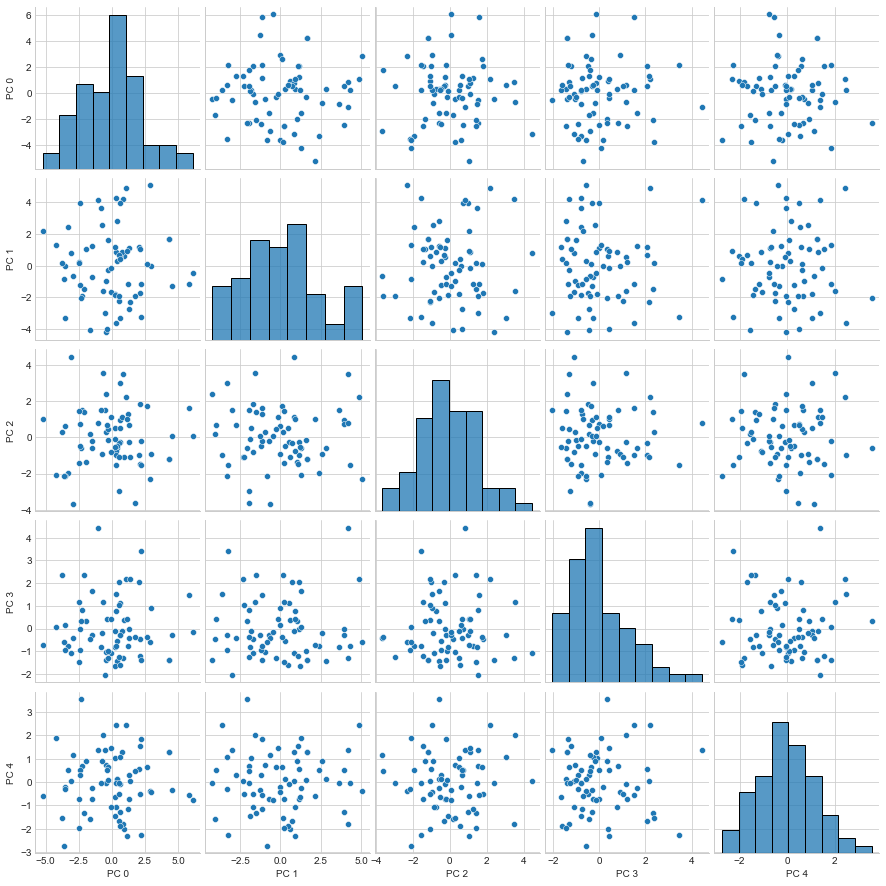

In [9]:
plt.figure(figsize = (12,7))
sns.pairplot(pd.DataFrame(pca_selected_data, columns = columns))


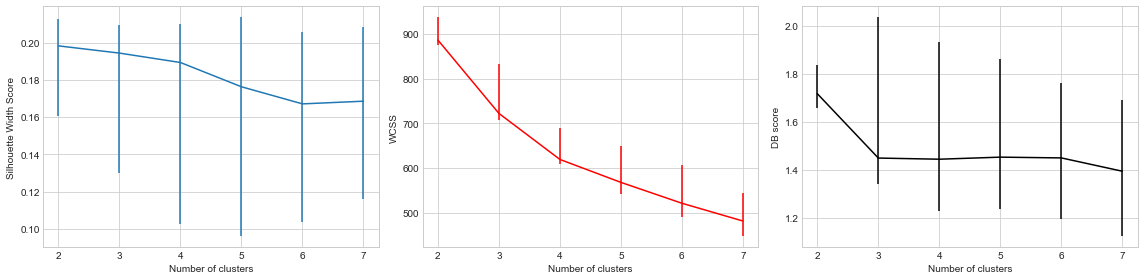

In [10]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

n_clusters = np.arange(2,8)
l = 200 #The number of times kmeans will be restarted.

sil_score_kmeans = np.zeros((len(n_clusters), l), dtype = float)
wcss_score_kmeans = np.zeros((len(n_clusters), l), dtype = float)
db_score_kmeans = np.zeros((len(n_clusters), l), dtype = float)

for i,k in enumerate(n_clusters):
    for j in range(l):
        kmeans = KMeans(n_clusters = k, n_init = 1).fit(pca_selected_data) #Kmeans is only run once internally
        
        sil_score_kmeans[i,j] = silhouette_score(pca_selected_data, kmeans.labels_)
        wcss_score_kmeans[i,j] = kmeans.inertia_
        db_score_kmeans[i,j] = davies_bouldin_score(pca_selected_data, kmeans.labels_)
fig, axis = plt.subplots(1,3, figsize = (16,4))

axis[0].errorbar(
                n_clusters,
    np.median(sil_score_kmeans, axis = 1),
    [
        
        np.median(sil_score_kmeans, axis = 1) - np.min(sil_score_kmeans, axis = 1),
        np.max(sil_score_kmeans, axis = 1) - np.median(sil_score_kmeans, axis = 1)
        
    ],

)

axis[0].set_xlabel("Number of clusters")
axis[0].set_ylabel("Silhouette Width Score")

axis[1].errorbar(
                n_clusters,
    np.median(wcss_score_kmeans, axis = 1),
    [
        
        np.median(wcss_score_kmeans, axis = 1) - np.min(wcss_score_kmeans, axis = 1),
        np.max(wcss_score_kmeans, axis = 1) - np.median(wcss_score_kmeans, axis = 1)
        
    ], color = 'red'

)

axis[1].set_xlabel("Number of clusters")
axis[1].set_ylabel("WCSS")


axis[2].errorbar(
                n_clusters,
    np.median(db_score_kmeans, axis = 1),
    [
        
        np.median(db_score_kmeans, axis = 1) - np.min(db_score_kmeans, axis = 1),
        np.max(db_score_kmeans, axis = 1) - np.median(db_score_kmeans, axis = 1)
        
    ], color = 'black'

)

axis[2].set_xlabel("Number of clusters")
axis[2].set_ylabel("DB score")



fig.tight_layout()


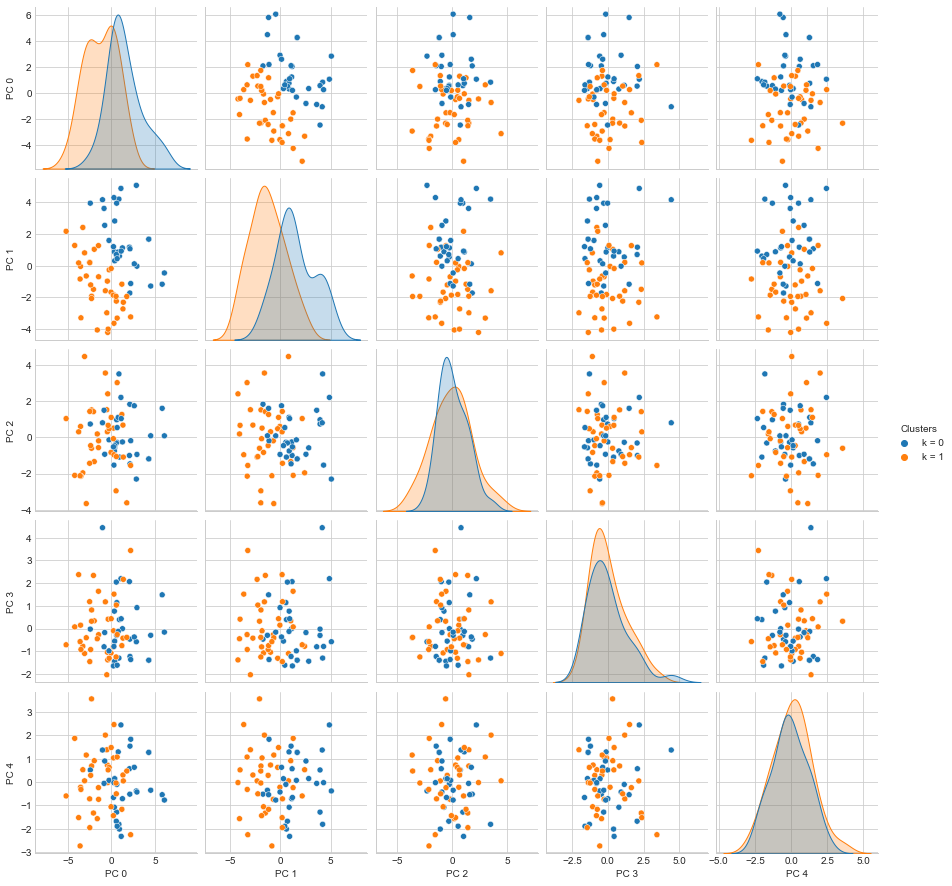

In [11]:
a = pd.DataFrame({"Clusters": [f"k = {i}" for i in KMeans(n_clusters = 2, n_init = 200).fit(pca_selected_data).labels_]})
b = pd.DataFrame(pca_selected_data, columns = columns)
y = pd.concat([a,b], axis = 1)
sns.pairplot(y, hue = "Clusters", hue_order = ["k = 0", "k = 1"])


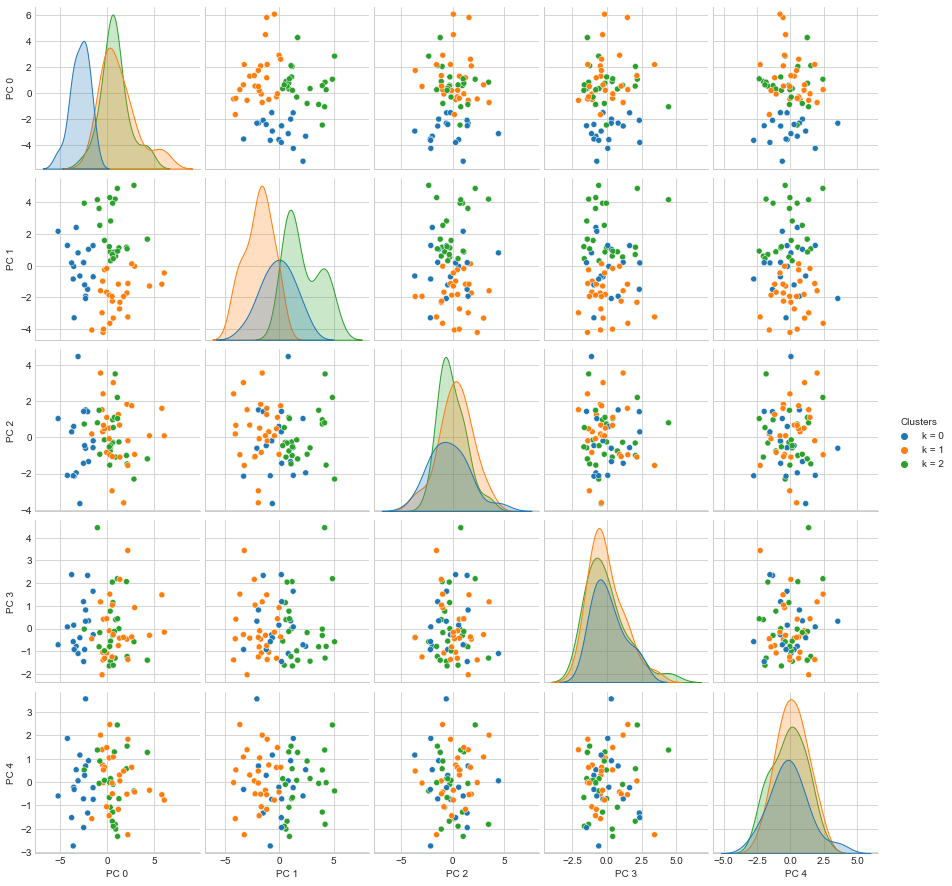

In [12]:
a = pd.DataFrame({"Clusters": [f"k = {i}" for i in KMeans(n_clusters = 3, n_init = 200).fit(pca_selected_data).labels_]})
b = pd.DataFrame(pca_selected_data, columns = columns)
y = pd.concat([a,b], axis = 1)
sns.pairplot(y, hue = "Clusters", hue_order = ["k = 0", "k = 1", "k = 2"])


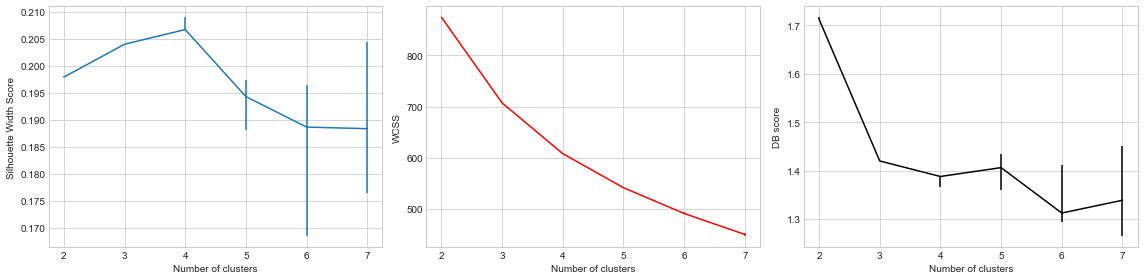

In [13]:
n_clusters = np.arange(2,8)
l = 20 #The number of times kmeans will be restarted.

sil_score_kmeans2 = np.zeros((len(n_clusters), l), dtype = float)
wcss_score_kmeans2 = np.zeros((len(n_clusters), l), dtype = float)
db_score_kmeans2 = np.zeros((len(n_clusters), l), dtype = float)

for i,k in enumerate(n_clusters):
    for j in range(l):
        kmeans = KMeans(n_clusters = k, n_init = 150).fit(pca_selected_data) #Kmeans is only run once internally
        
        sil_score_kmeans2[i,j] = silhouette_score(pca_selected_data, kmeans.labels_)
        wcss_score_kmeans2[i,j] = kmeans.inertia_
        db_score_kmeans2[i,j] = davies_bouldin_score(pca_selected_data, kmeans.labels_)
fig, axis = plt.subplots(1,3, figsize = (16,4))

axis[0].errorbar(
                n_clusters,
    np.median(sil_score_kmeans2, axis = 1),
    [
        
        np.median(sil_score_kmeans2, axis = 1) - np.min(sil_score_kmeans2, axis = 1),
        np.max(sil_score_kmeans2, axis = 1) - np.median(sil_score_kmeans2, axis = 1)
        
    ],

)

axis[0].set_xlabel("Number of clusters")
axis[0].set_ylabel("Silhouette Width Score")

axis[1].errorbar(
                n_clusters,
    np.median(wcss_score_kmeans2, axis = 1),
    [
        
        np.median(wcss_score_kmeans2, axis = 1) - np.min(wcss_score_kmeans2, axis = 1),
        np.max(wcss_score_kmeans2, axis = 1) - np.median(wcss_score_kmeans2, axis = 1)
        
    ], color = 'red'

)

axis[1].set_xlabel("Number of clusters")
axis[1].set_ylabel("WCSS")


axis[2].errorbar(
                n_clusters,
    np.median(db_score_kmeans2, axis = 1),
    [
        
        np.median(db_score_kmeans2, axis = 1) - np.min(db_score_kmeans2, axis = 1),
        np.max(db_score_kmeans2, axis = 1) - np.median(db_score_kmeans2, axis = 1)
        
    ], color = 'black'

)

axis[2].set_xlabel("Number of clusters")
axis[2].set_ylabel("DB score")



fig.tight_layout()


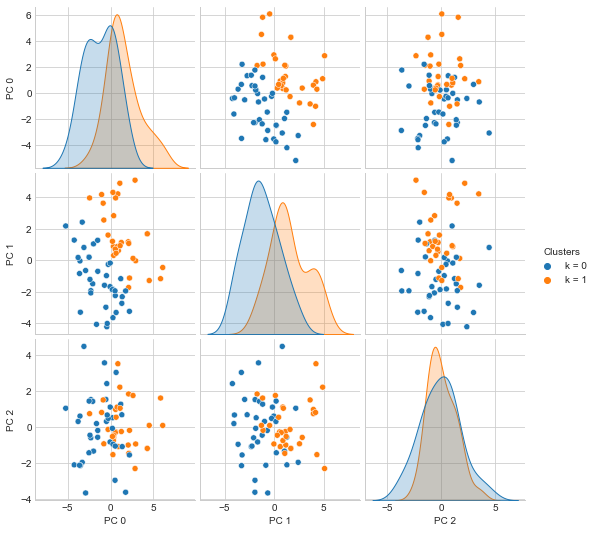

In [14]:
a = pd.DataFrame({"Clusters": [f"k = {i}" for i in KMeans(n_clusters = 2, n_init = 200).fit(pca_selected_data).labels_]})
b = pd.DataFrame(pca_selected_data, columns = columns).iloc[:,:3]
y = pd.concat([a,b], axis = 1)
sns.pairplot(y, hue = "Clusters", hue_order = ["k = 0", "k = 1"])


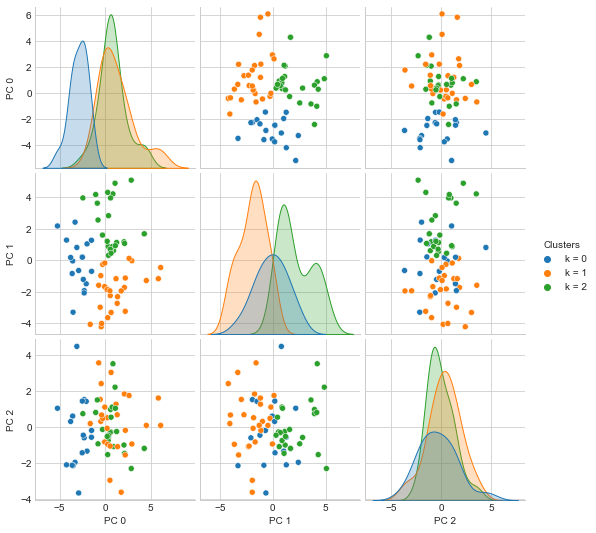

In [15]:
a = pd.DataFrame({"Clusters": [f"k = {i}" for i in KMeans(n_clusters = 3, n_init = 200).fit(pca_selected_data).labels_]})
b = pd.DataFrame(pca_selected_data, columns = columns).iloc[:,:3]
y = pd.concat([a,b], axis = 1)
sns.pairplot(y, hue = "Clusters", hue_order = ["k = 0", "k = 1", "k = 2"])


In [17]:

i = 0
df_list = []
for xml_file in os.listdir("../Timeseries"):
    if xml_file.startswith("timeseries"):
        #print(xml_file)
        bs_data = read_data("../Timeseries/" + xml_file)
        b_name = bs_data.find_all('name')
        try:
            df1 = calc_euclidian_distances(bs_data, 0, int(len(b_name)/4))
            df1 = pd.DataFrame(df1.std().to_dict(),index=[df1.index.values[-1]])
            df1 = df1.rename(index={100:i})

            df_list.append(df1)
        except:
            print(xml_file + " failed to compute")
        i += 1

data = pd.concat(df_list)

timeseries-11.xml failed to compute
timeseries-45.xml failed to compute
timeseries-6.xml failed to compute


C:\Users\linne\Documents\Chalmers\Tracks\BikeFit\env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Histogram of feature means'}, xlabel='Means', ylabel='Frequency'>

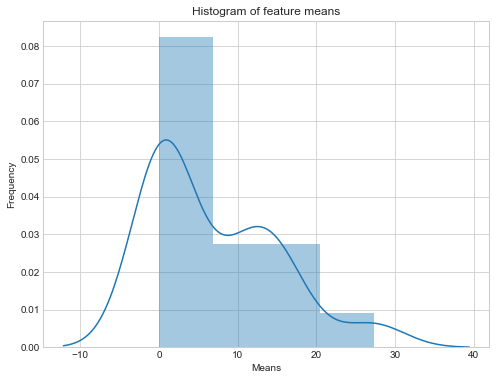

In [18]:
feature_means = data.mean(axis=0)

plt.figure(figsize = (8,6))
plt.title('Histogram of feature means')
plt.xlabel('Means')
plt.ylabel('Frequency')
sns.distplot(a = feature_means)

C:\Users\linne\Documents\Chalmers\Tracks\BikeFit\env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Histogram of feature variances'}, xlabel='Variances', ylabel='Frequency'>

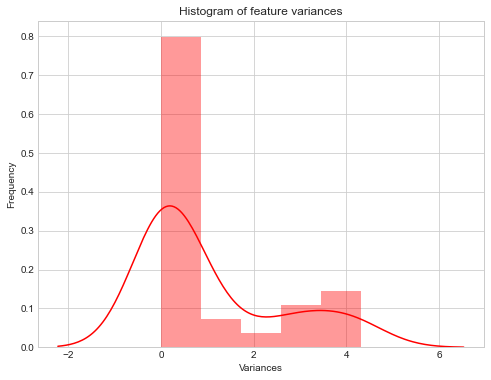

In [19]:
feature_var = data.var(axis = 0)
plt.figure(figsize = (8,6))
plt.title('Histogram of feature variances')
plt.xlabel('Variances')
plt.ylabel('Frequency')
sns.distplot(a = feature_var, color = 'r')


Text(0, 0.5, 'Explained variance')

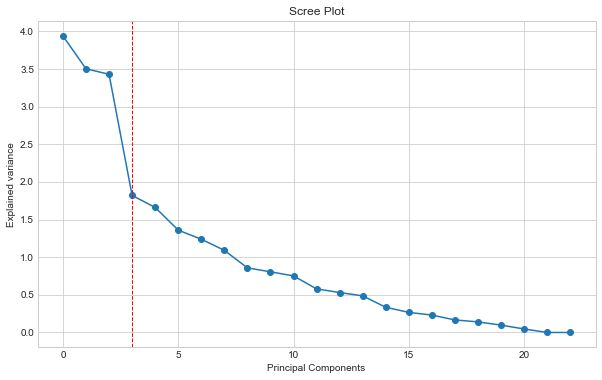

In [20]:
data.loc[:, (data == "null").any(axis = 0) ]

na = data.dropna(axis=1)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(na)
pca = PCA().fit(scaled_data)
pca_reduced_data = pca.transform(scaled_data)

plt.figure(figsize = (10,6))
plt.plot(range(23), pca.explained_variance_[:50], '-o')
plt.axvline(3, color = 'red', linestyle = 'dashed', linewidth = 1)
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained variance')


<Figure size 864x504 with 0 Axes>

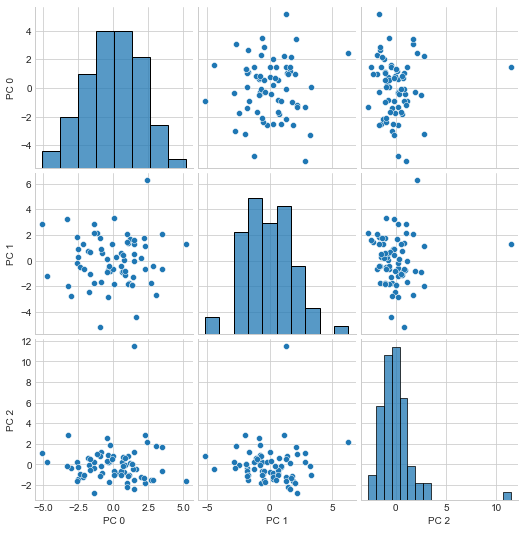

In [21]:
pca_selected_data = pca_reduced_data[:, :5]
pca_selected_data.shape[1]
columns = []
for i in range(pca_selected_data.shape[1]):
    columns.append(f"PC {i}")
plt.figure(figsize = (12,7))
sns.pairplot(pd.DataFrame(pca_selected_data, columns = columns).iloc[:,:3])


<Figure size 864x504 with 0 Axes>

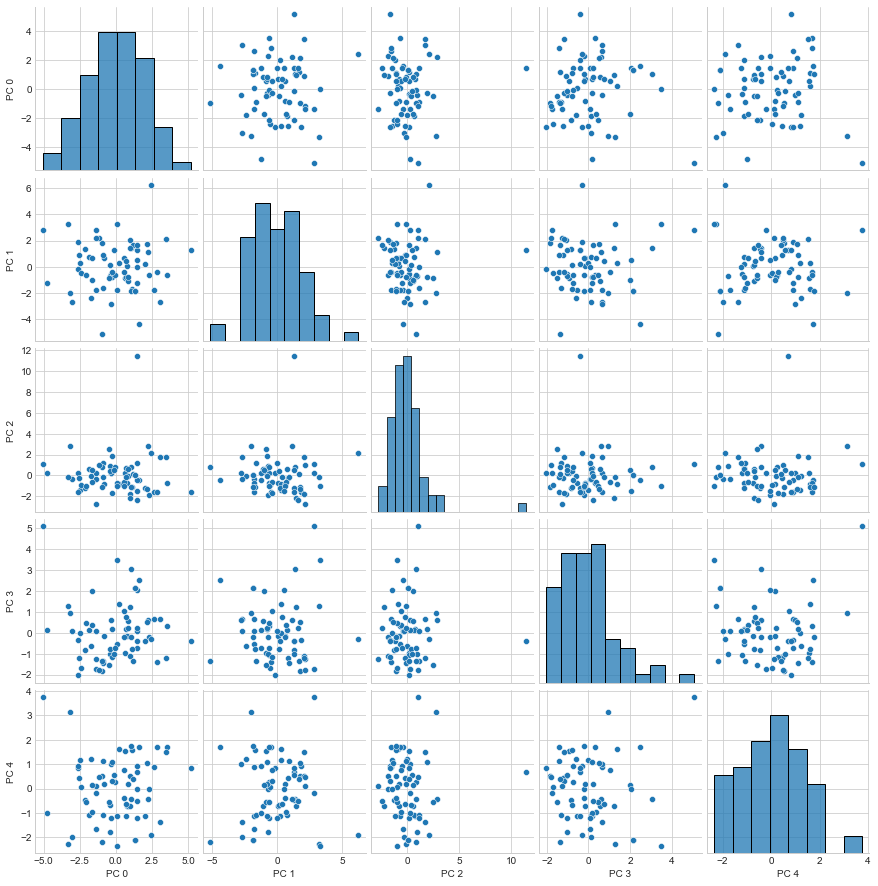

In [22]:
plt.figure(figsize = (12,7))
sns.pairplot(pd.DataFrame(pca_selected_data, columns = columns))


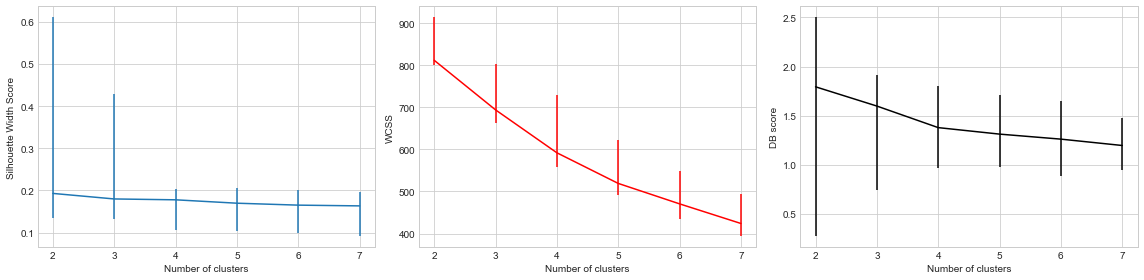

In [23]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

n_clusters = np.arange(2,8)
l = 200 #The number of times kmeans will be restarted.

sil_score_kmeans = np.zeros((len(n_clusters), l), dtype = float)
wcss_score_kmeans = np.zeros((len(n_clusters), l), dtype = float)
db_score_kmeans = np.zeros((len(n_clusters), l), dtype = float)

for i,k in enumerate(n_clusters):
    for j in range(l):
        kmeans = KMeans(n_clusters = k, n_init = 1).fit(pca_selected_data) #Kmeans is only run once internally
        
        sil_score_kmeans[i,j] = silhouette_score(pca_selected_data, kmeans.labels_)
        wcss_score_kmeans[i,j] = kmeans.inertia_
        db_score_kmeans[i,j] = davies_bouldin_score(pca_selected_data, kmeans.labels_)
fig, axis = plt.subplots(1,3, figsize = (16,4))

axis[0].errorbar(
                n_clusters,
    np.median(sil_score_kmeans, axis = 1),
    [
        
        np.median(sil_score_kmeans, axis = 1) - np.min(sil_score_kmeans, axis = 1),
        np.max(sil_score_kmeans, axis = 1) - np.median(sil_score_kmeans, axis = 1)
        
    ],

)

axis[0].set_xlabel("Number of clusters")
axis[0].set_ylabel("Silhouette Width Score")

axis[1].errorbar(
                n_clusters,
    np.median(wcss_score_kmeans, axis = 1),
    [
        
        np.median(wcss_score_kmeans, axis = 1) - np.min(wcss_score_kmeans, axis = 1),
        np.max(wcss_score_kmeans, axis = 1) - np.median(wcss_score_kmeans, axis = 1)
        
    ], color = 'red'

)

axis[1].set_xlabel("Number of clusters")
axis[1].set_ylabel("WCSS")


axis[2].errorbar(
                n_clusters,
    np.median(db_score_kmeans, axis = 1),
    [
        
        np.median(db_score_kmeans, axis = 1) - np.min(db_score_kmeans, axis = 1),
        np.max(db_score_kmeans, axis = 1) - np.median(db_score_kmeans, axis = 1)
        
    ], color = 'black'

)

axis[2].set_xlabel("Number of clusters")
axis[2].set_ylabel("DB score")



fig.tight_layout()


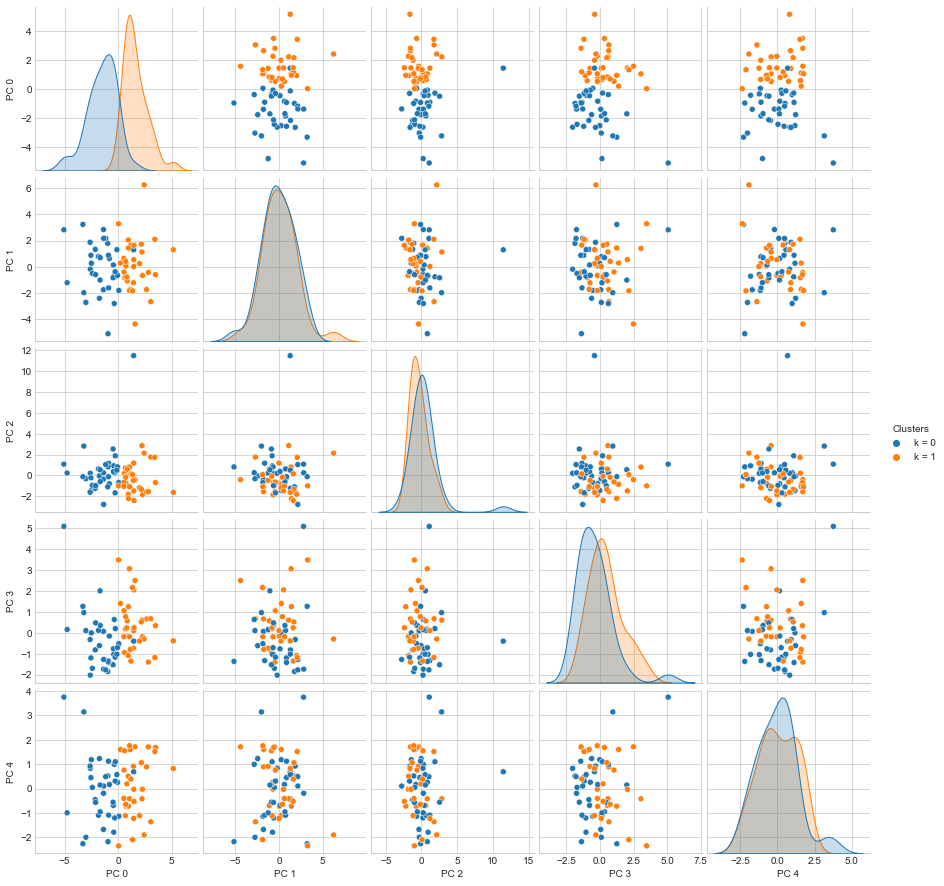

In [24]:
a = pd.DataFrame({"Clusters": [f"k = {i}" for i in KMeans(n_clusters = 2, n_init = 200).fit(pca_selected_data).labels_]})
b = pd.DataFrame(pca_selected_data, columns = columns)
y = pd.concat([a,b], axis = 1)
sns.pairplot(y, hue = "Clusters", hue_order = ["k = 0", "k = 1"])


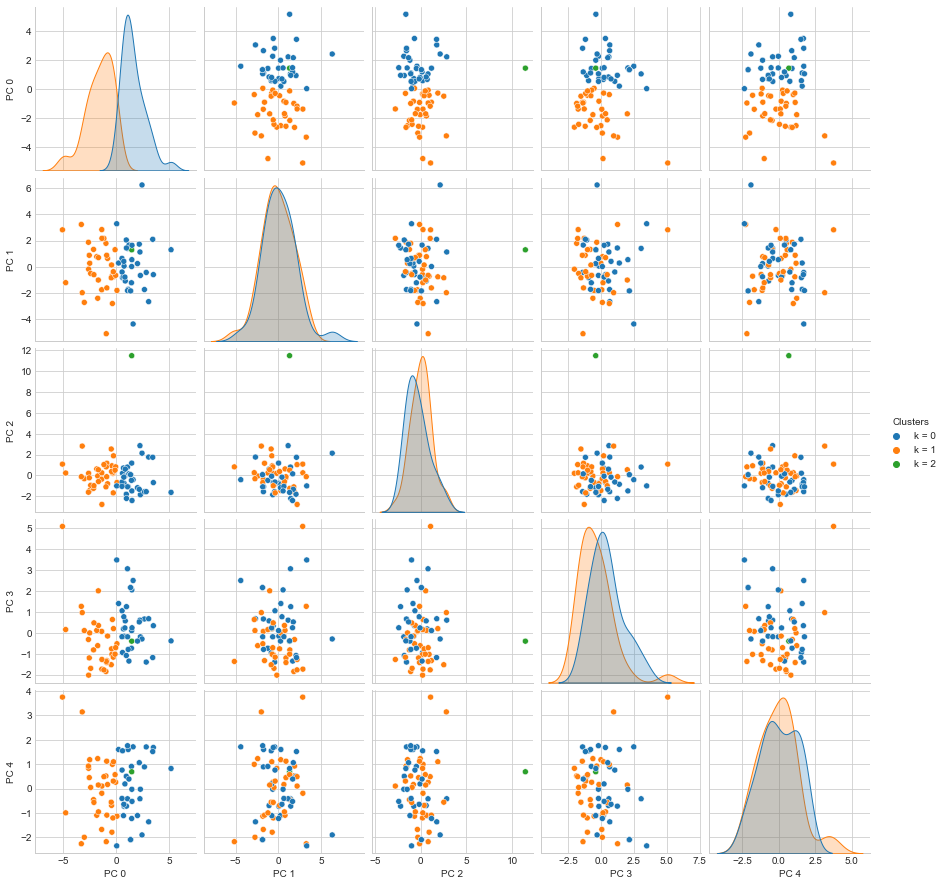

In [25]:
a = pd.DataFrame({"Clusters": [f"k = {i}" for i in KMeans(n_clusters = 3, n_init = 200).fit(pca_selected_data).labels_]})
b = pd.DataFrame(pca_selected_data, columns = columns)
y = pd.concat([a,b], axis = 1)
sns.pairplot(y, hue = "Clusters", hue_order = ["k = 0", "k = 1", "k = 2"])


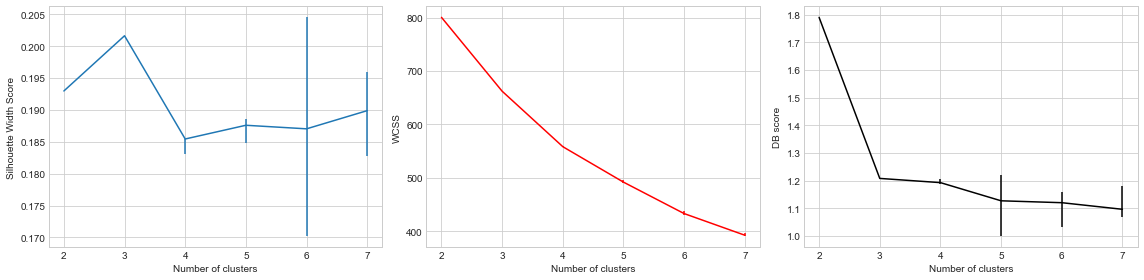

In [26]:
n_clusters = np.arange(2,8)
l = 20 #The number of times kmeans will be restarted.

sil_score_kmeans2 = np.zeros((len(n_clusters), l), dtype = float)
wcss_score_kmeans2 = np.zeros((len(n_clusters), l), dtype = float)
db_score_kmeans2 = np.zeros((len(n_clusters), l), dtype = float)

for i,k in enumerate(n_clusters):
    for j in range(l):
        kmeans = KMeans(n_clusters = k, n_init = 150).fit(pca_selected_data) #Kmeans is only run once internally
        
        sil_score_kmeans2[i,j] = silhouette_score(pca_selected_data, kmeans.labels_)
        wcss_score_kmeans2[i,j] = kmeans.inertia_
        db_score_kmeans2[i,j] = davies_bouldin_score(pca_selected_data, kmeans.labels_)
fig, axis = plt.subplots(1,3, figsize = (16,4))

axis[0].errorbar(
                n_clusters,
    np.median(sil_score_kmeans2, axis = 1),
    [
        
        np.median(sil_score_kmeans2, axis = 1) - np.min(sil_score_kmeans2, axis = 1),
        np.max(sil_score_kmeans2, axis = 1) - np.median(sil_score_kmeans2, axis = 1)
        
    ],

)

axis[0].set_xlabel("Number of clusters")
axis[0].set_ylabel("Silhouette Width Score")

axis[1].errorbar(
                n_clusters,
    np.median(wcss_score_kmeans2, axis = 1),
    [
        
        np.median(wcss_score_kmeans2, axis = 1) - np.min(wcss_score_kmeans2, axis = 1),
        np.max(wcss_score_kmeans2, axis = 1) - np.median(wcss_score_kmeans2, axis = 1)
        
    ], color = 'red'

)

axis[1].set_xlabel("Number of clusters")
axis[1].set_ylabel("WCSS")


axis[2].errorbar(
                n_clusters,
    np.median(db_score_kmeans2, axis = 1),
    [
        
        np.median(db_score_kmeans2, axis = 1) - np.min(db_score_kmeans2, axis = 1),
        np.max(db_score_kmeans2, axis = 1) - np.median(db_score_kmeans2, axis = 1)
        
    ], color = 'black'

)

axis[2].set_xlabel("Number of clusters")
axis[2].set_ylabel("DB score")



fig.tight_layout()


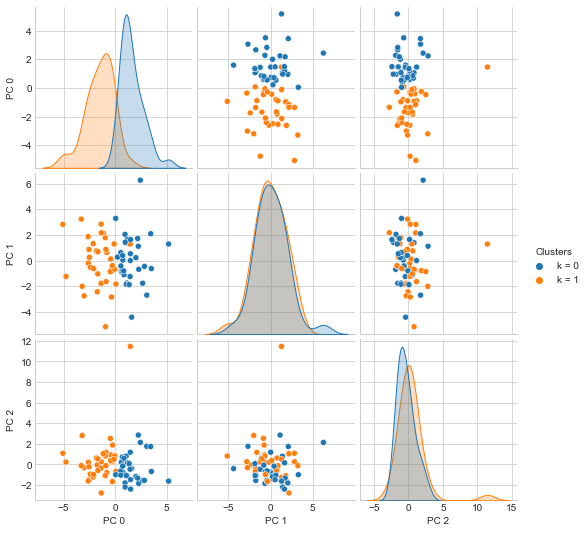

In [27]:
a = pd.DataFrame({"Clusters": [f"k = {i}" for i in KMeans(n_clusters = 2, n_init = 200).fit(pca_selected_data).labels_]})
b = pd.DataFrame(pca_selected_data, columns = columns).iloc[:,:3]
y = pd.concat([a,b], axis = 1)
sns.pairplot(y, hue = "Clusters", hue_order = ["k = 0", "k = 1"])


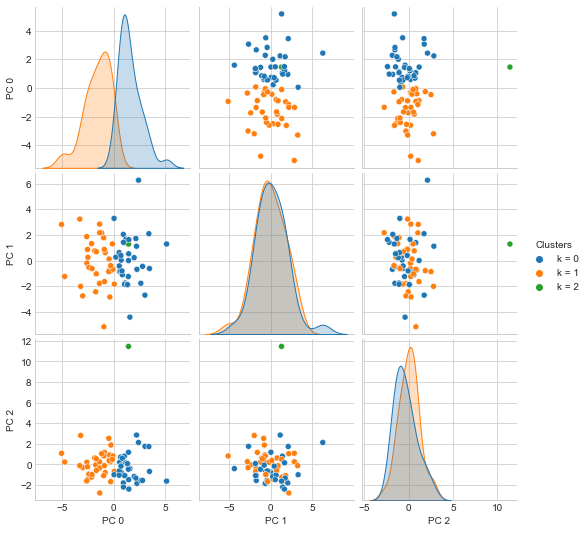

In [28]:
a = pd.DataFrame({"Clusters": [f"k = {i}" for i in KMeans(n_clusters = 3, n_init = 200).fit(pca_selected_data).labels_]})
b = pd.DataFrame(pca_selected_data, columns = columns).iloc[:,:3]
y = pd.concat([a,b], axis = 1)
sns.pairplot(y, hue = "Clusters", hue_order = ["k = 0", "k = 1", "k = 2"])


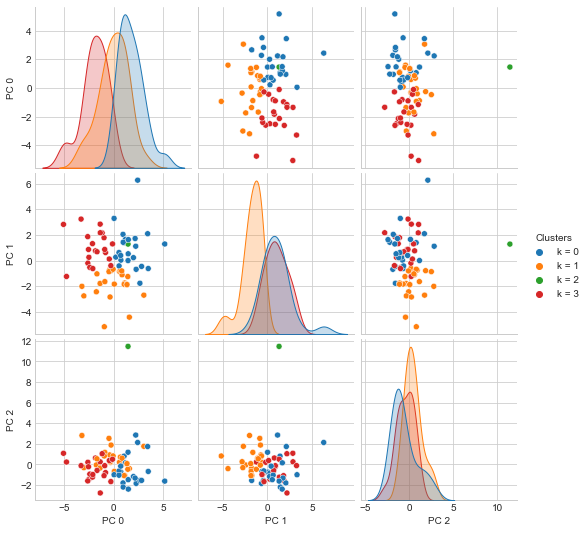

In [29]:
a = pd.DataFrame({"Clusters": [f"k = {i}" for i in KMeans(n_clusters = 4, n_init = 200).fit(pca_selected_data).labels_]})
b = pd.DataFrame(pca_selected_data, columns = columns).iloc[:,:3]
y = pd.concat([a,b], axis = 1)
sns.pairplot(y, hue = "Clusters", hue_order = ["k = 0", "k = 1", "k = 2", "k = 3"])


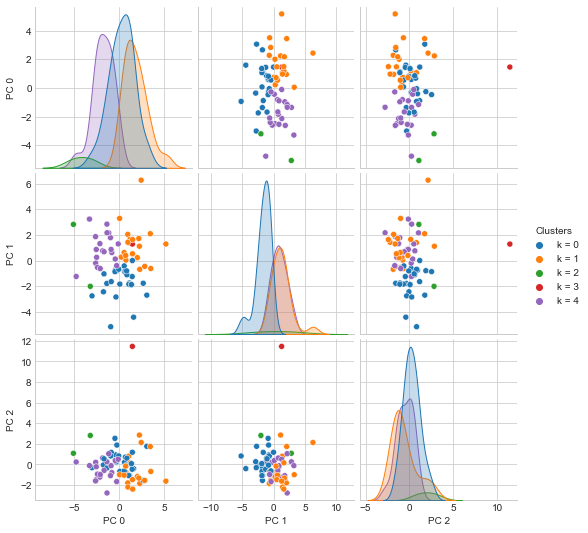

In [30]:
a = pd.DataFrame({"Clusters": [f"k = {i}" for i in KMeans(n_clusters = 5, n_init = 200).fit(pca_selected_data).labels_]})
b = pd.DataFrame(pca_selected_data, columns = columns).iloc[:,:3]
y = pd.concat([a,b], axis = 1)
sns.pairplot(y, hue = "Clusters", hue_order = ["k = 0", "k = 1", "k = 2", "k = 3", "k = 4"])
